In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.4.1.tar.gz (1.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
     ---------------------------------------- 7.6/7.6 MB 166.9 kB/s eta 0:00:00
  Using cached albumentations-1.4.0-py3-none-any.whl (123 kB)
  Using cached gdown-5.1.0-py3-none-any.whl (17 kB)
  Using cached imgviz-1.7.5.tar.gz (7.7 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
     ---------------------------------------- 15.8/15.8 MB 1.1 MB/s eta 0:00:00
  Using cached onnxruntime-1.17.1-cp311-cp311-win_amd64.whl (5.6 MB)
     ---------------------------------------- 2.6/2.6 MB 1.8 MB/s eta 0:00:00
     -------------------------------------- 144.7/144.7 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 93.5/93.5 kB 1.8 MB/s eta 0:00:00


  DEPRECATION: imgviz is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: labelme is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os 
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [12]:
!labelme

2024-03-01 01:14:39,376 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\razae\.labelmerc


In [13]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
tf.config.list_physical_devices('GPU')

[]

In [16]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [17]:
images.as_numpy_iterator().next()

b'data\\images\\c3c06e0d-d737-11ee-968b-70a6cc6a1066.jpg'

In [18]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[111, 147, 171],
        [115, 151, 175],
        [116, 152, 174],
        ...,
        [ 87,  87,  89],
        [ 79,  78,  83],
        [ 85,  84,  89]],

       [[111, 147, 171],
        [110, 146, 168],
        [110, 146, 168],
        ...,
        [ 91,  91,  93],
        [ 82,  81,  86],
        [ 82,  81,  86]],

       [[113, 149, 171],
        [109, 145, 167],
        [109, 145, 167],
        ...,
        [ 91,  90,  95],
        [ 85,  84,  89],
        [ 80,  79,  84]],

       ...,

       [[ 58,  36,  13],
        [ 59,  38,  17],
        [ 60,  37,  19],
        ...,
        [ 52,  60,  62],
        [ 54,  63,  60],
        [ 57,  66,  61]],

       [[ 60,  33,  22],
        [ 58,  34,  22],
        [ 60,  33,  22],
        ...,
        [ 55,  60,  66],
        [ 54,  59,  62],
        [ 52,  58,  56]],

       [[ 65,  38,  31],
        [ 63,  36,  29],
        [ 62,  35,  26],
        ...,
        [ 59,  63,  72],
        [ 54,  58,  61],
        [ 47,  51,  52]]

In [21]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [22]:
image_generator = images.batch(4).as_numpy_iterator()

In [29]:
plot_images = image_generator.next()

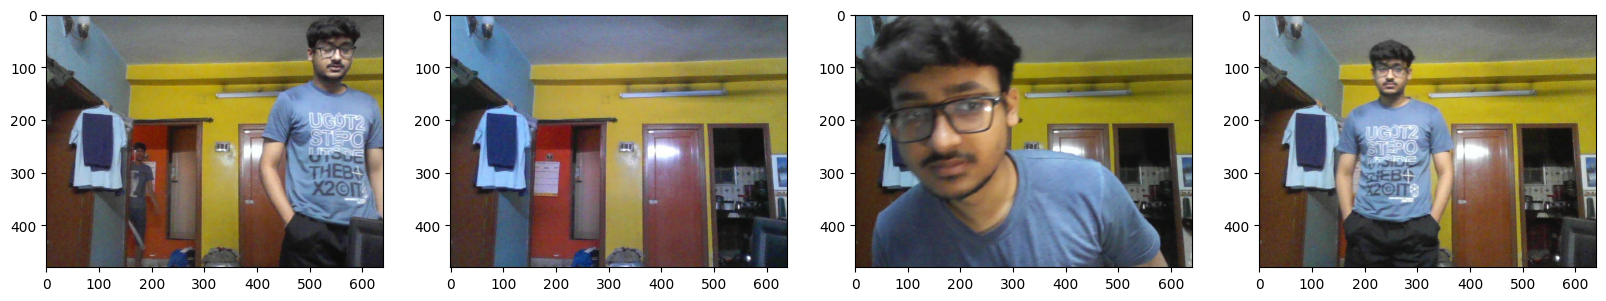

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [33]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

In [34]:
import albumentations as alb

In [38]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [39]:
img = cv2.imread(os.path.join('data','train', 'images','c3c06e0d-d737-11ee-968b-70a6cc6a1066.jpg'))

In [41]:
with open(os.path.join('data', 'train', 'labels', 'c3c06e0d-d737-11ee-968b-70a6cc6a1066.json'), 'r') as f:
    label = json.load(f)

In [63]:
label['shapes'][0]['points']

[[519.7222222222222, 60.55555555555555], [639.0, 285.24160206718335]]

In [64]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [65]:
coords

[519.7222222222222, 60.55555555555555, 639.0, 285.24160206718335]

In [66]:
coords = list(np.divide(coords, [640,480,640,480]))

In [67]:
coords

[0.8120659722222221, 0.12615740740740738, 0.9984375, 0.5942533376399654]

In [68]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [72]:
augmented['bboxes'][0][2:]

(1.0, 0.573870226815963)

In [73]:
augmented['bboxes']

[(0.7882716049382715, 0.07456790123456787, 1.0, 0.573870226815963)]

In [97]:
augmented['image']

array([[[ 95,  97,  97],
        [ 94,  97,  95],
        [ 91,  94,  92],
        ...,
        [169, 145, 122],
        [164, 140, 117],
        [169, 145, 122]],

       [[ 96,  98,  98],
        [ 95,  98,  96],
        [ 93,  96,  94],
        ...,
        [180, 156, 133],
        [172, 148, 125],
        [170, 146, 123]],

       [[ 97, 100,  98],
        [ 97, 101,  96],
        [ 96, 100,  95],
        ...,
        [177, 154, 130],
        [173, 150, 125],
        [172, 149, 124]],

       ...,

       [[ 61,  35,  41],
        [ 53,  27,  33],
        [ 60,  28,  35],
        ...,
        [ 34,  50,  81],
        [ 30,  46,  77],
        [ 31,  50,  75]],

       [[ 44,  30,  37],
        [ 45,  33,  36],
        [ 51,  34,  38],
        ...,
        [ 33,  52,  80],
        [ 37,  55,  80],
        [ 42,  61,  83]],

       [[ 40,  33,  38],
        [ 38,  33,  35],
        [ 42,  33,  34],
        ...,
        [ 30,  50,  78],
        [ 31,  50,  75],
        [ 37,  53,  77]]

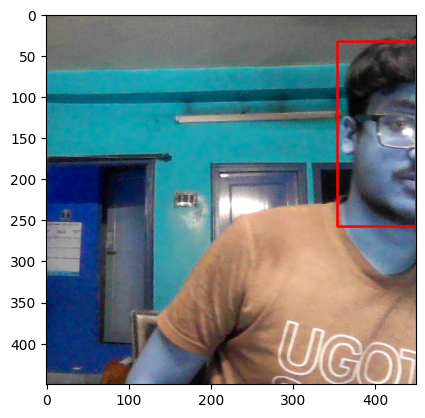

In [74]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [75]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2651909722222222, 0.2650462962962963, 0.0, 0.7150673400673401, 'face'].
x_max is less than or equal to x_min for bbox [0.16449652777777776, 0.3101851851851852, 0.0, 0.8026203035968661, 'face'].
x_max is less than or equal to x_min for bbox [0.19401041666666669, 0.27199074074074076, 0.0, 0.7678803432879521, 'face'].
x_max is less than or equal to x_min for bbox [0.4830729166666667, 0.9953703703703703, 0.015190972222222232, 0.42939814814814814, 'face'].
x_max is less than or equal to x_min for bbox [0.8250868055555557, 0.03472222222222222, 0.5464409722222222, 0.45254629629629634, 'face'].
x_max is less than or equal to x_min for bbox [0.17838541666666666, 0.2106481481481481, 0.0, 0.004665625553783433, 'face'].
y_max is less than or equal to y_min for bbox [0.4657118055555555, 0.19791666666666666, 0.6488715277777778, 0.0023148148148148143, 'face'].
x_max is less than or equal to x_min for bbox [0.6592881944444444, 0.23148148148148145, 0.495

In [76]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [77]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [78]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [79]:
train_images.as_numpy_iterator().next()

array([[[0.5014093 , 0.5092524 , 0.5004289 ],
        [0.5269608 , 0.5271446 , 0.5230392 ],
        [0.5072304 , 0.5185049 , 0.453799  ],
        ...,
        [0.60655636, 0.63890934, 0.628125  ],
        [0.5932598 , 0.6215686 , 0.6120711 ],
        [0.60545343, 0.6211397 , 0.6299632 ]],

       [[0.5287377 , 0.5336397 , 0.5262868 ],
        [0.55018383, 0.55018383, 0.54920346],
        [0.530576  , 0.5375    , 0.49724266],
        ...,
        [0.6077819 , 0.67218137, 0.64957106],
        [0.6103554 , 0.6552696 , 0.63915443],
        [0.6001226 , 0.6245711 , 0.62034315]],

       [[0.5423407 , 0.55018383, 0.54626226],
        [0.5735907 , 0.5735907 , 0.57959557],
        [0.521875  , 0.52230394, 0.513174  ],
        ...,
        [0.62371325, 0.62653184, 0.62561274],
        [0.6417892 , 0.6510417 , 0.63982844],
        [0.6223652 , 0.6405637 , 0.6261642 ]],

       ...,

       [[0.86966914, 0.88143384, 0.8457721 ],
        [0.7153799 , 0.7143995 , 0.6668505 ],
        [0.44307598, 0

In [80]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [81]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [82]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [83]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [84]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.52  , 0.2291, 0.8374, 0.6167], dtype=float16))

In [85]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2760, 2760, 660, 660, 600, 600)

In [86]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [87]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [88]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [89]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.591 , 0.4297, 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2683, 0.483 , 0.5796, 0.861 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.41  , 0.1613, 0.763 , 0.5884],
        [0.3909, 0.1697, 0.698 , 0.544 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2598, 0.2708, 0.561 , 0.6274]], dtype=float16))

In [103]:
data_samples = train.as_numpy_iterator()

In [111]:
res = data_samples.next()

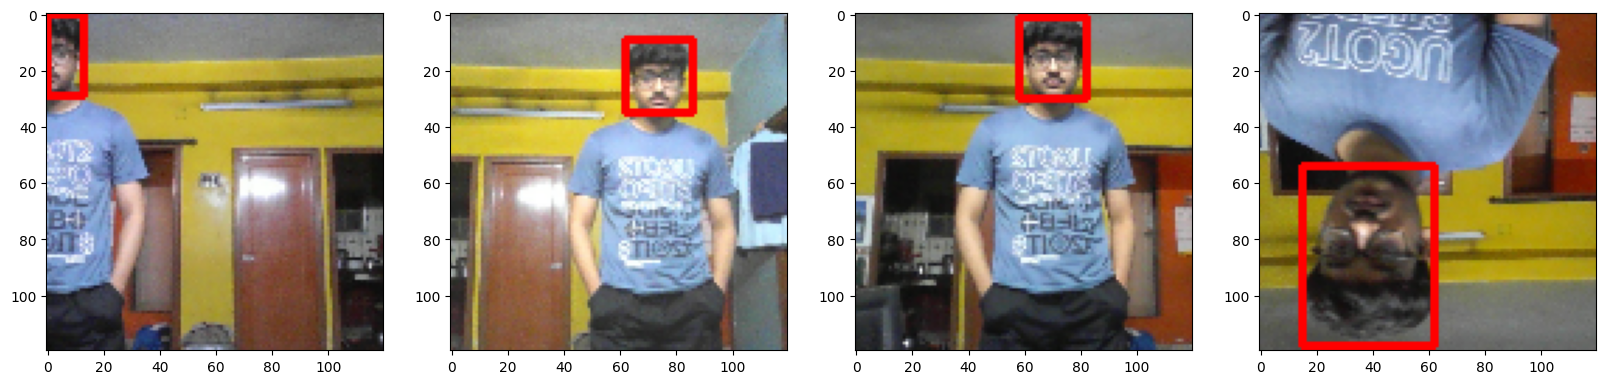

In [112]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (res[0][idx]*255).astype(np.uint8)
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [113]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [114]:
vgg = VGG16(include_top=False)



58889256/58889256 [==============================] - 10s 0us/step


In [115]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [121]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [122]:
facetracker = build_model()

In [123]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_6[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [124]:
X, y = train.as_numpy_iterator().next()

In [131]:
X.shape

(8, 120, 120, 3)

In [128]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [129]:
classes, coords

(array([[0.6648553 ],
        [0.5279526 ],
        [0.5843688 ],
        [0.56255376],
        [0.54973537],
        [0.60895514],
        [0.5733442 ],
        [0.5852113 ]], dtype=float32),
 array([[0.30506197, 0.27221125, 0.37162548, 0.280803  ],
        [0.30863026, 0.20250975, 0.43979806, 0.35985658],
        [0.21826567, 0.21664041, 0.39602256, 0.30356637],
        [0.31158864, 0.30690306, 0.45396334, 0.35239086],
        [0.31177643, 0.23938303, 0.40003383, 0.30773163],
        [0.16525804, 0.23606263, 0.35410246, 0.34064314],
        [0.29322293, 0.2741131 , 0.41146043, 0.3461636 ],
        [0.2875742 , 0.30319774, 0.3890069 , 0.334613  ]], dtype=float32))

In [144]:
initial_learning_rate = 0.0001
batches_per_epoch = len(train)
lr_decay = (1.0 / 0.75 - 1.0) / batches_per_epoch

In [148]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay*1000,
    staircase=False  # Set to True for discrete decay at integer multiples of decay_steps
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [149]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [150]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [151]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2936893>

In [152]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5681758>

In [153]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2936893>

In [154]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [155]:
model = FaceTracker(facetracker)

In [156]:
model.compile(opt, classloss, regressloss)

In [157]:
logdir='logs'

In [158]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [159]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
345/345 [==============================] - 700s 2s/step - total_loss: 0.3556 - class_loss: 0.0830 - regress_loss: 0.3142 - val_total_loss: 0.0411 - val_class_loss: 0.0024 - val_regress_loss: 0.0399
Epoch 2/10
345/345 [==============================] - 633s 2s/step - total_loss: 0.1046 - class_loss: 0.0299 - regress_loss: 0.0897 - val_total_loss: 0.0482 - val_class_loss: 0.0055 - val_regress_loss: 0.0454
Epoch 3/10
345/345 [==============================] - 643s 2s/step - total_loss: 0.0791 - class_loss: 0.0290 - regress_loss: 0.0646 - val_total_loss: 0.0708 - val_class_loss: 2.1473e-04 - val_regress_loss: 0.0707
Epoch 4/10
345/345 [==============================] - 712s 2s/step - total_loss: 0.0726 - class_loss: 0.0208 - regress_loss: 0.0622 - val_total_loss: 0.0355 - val_class_loss: 0.0065 - val_regress_loss: 0.0323
Epoch 5/10
345/345 [==============================] - 639s 2s/step - total_loss: 0.0522 - class_loss: 0.0148 - regress_loss: 0.0448 - val_total_loss: 0.0469 - v

In [160]:
hist.history

{'total_loss': [0.042868081480264664,
  0.07979512214660645,
  0.034750211983919144,
  0.03245287761092186,
  0.08304037153720856,
  0.011511754244565964,
  0.0024557318538427353,
  0.0046983505599200726,
  0.23836520314216614,
  0.010730897076427937],
 'class_loss': [0.008304007351398468,
  0.005414752755314112,
  0.0008798149065114558,
  0.009016595780849457,
  0.002415152033790946,
  2.42001551669091e-05,
  0.0004848774988204241,
  0.0011264458298683167,
  0.09139302372932434,
  0.0005217043217271566],
 'regress_loss': [0.03871607780456543,
  0.07708774507045746,
  0.03431030362844467,
  0.02794457972049713,
  0.08183279633522034,
  0.01149965450167656,
  0.002213293220847845,
  0.004135127644985914,
  0.19266869127750397,
  0.010470044799149036],
 'val_total_loss': [0.041095416992902756,
  0.04817672446370125,
  0.07080262154340744,
  0.03550302982330322,
  0.04687048867344856,
  0.021026860922574997,
  0.007804865017533302,
  0.01904977671802044,
  0.016320547088980675,
  0.011892

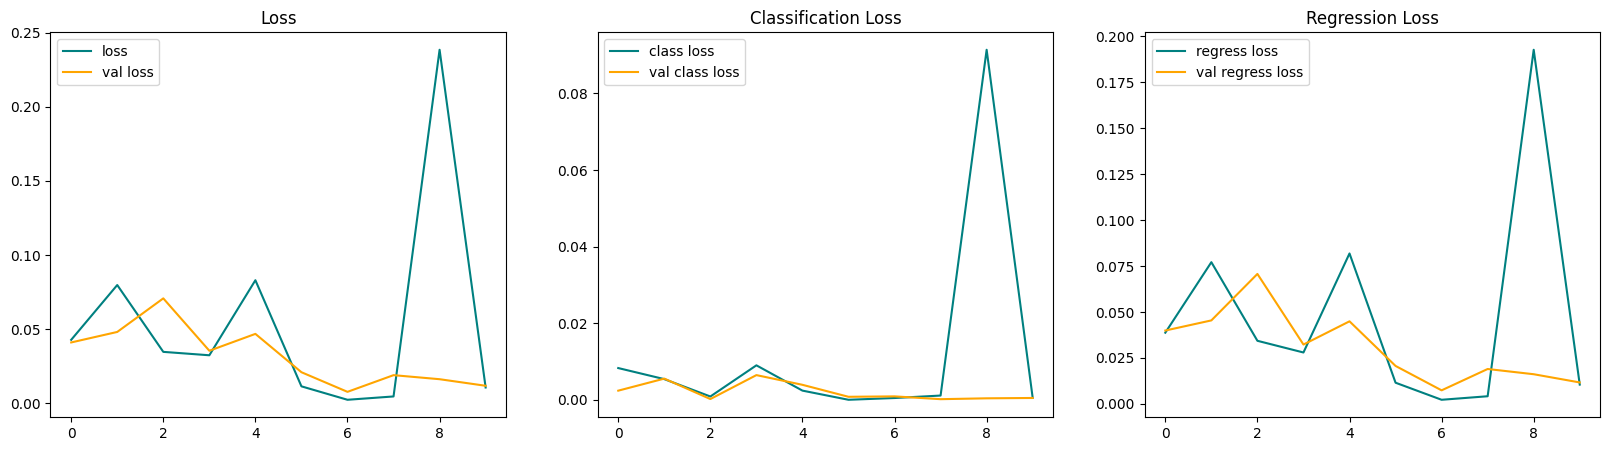

In [161]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [162]:
test_data = test.as_numpy_iterator()

In [182]:
test_sample = test_data.next()

In [183]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 265ms/step


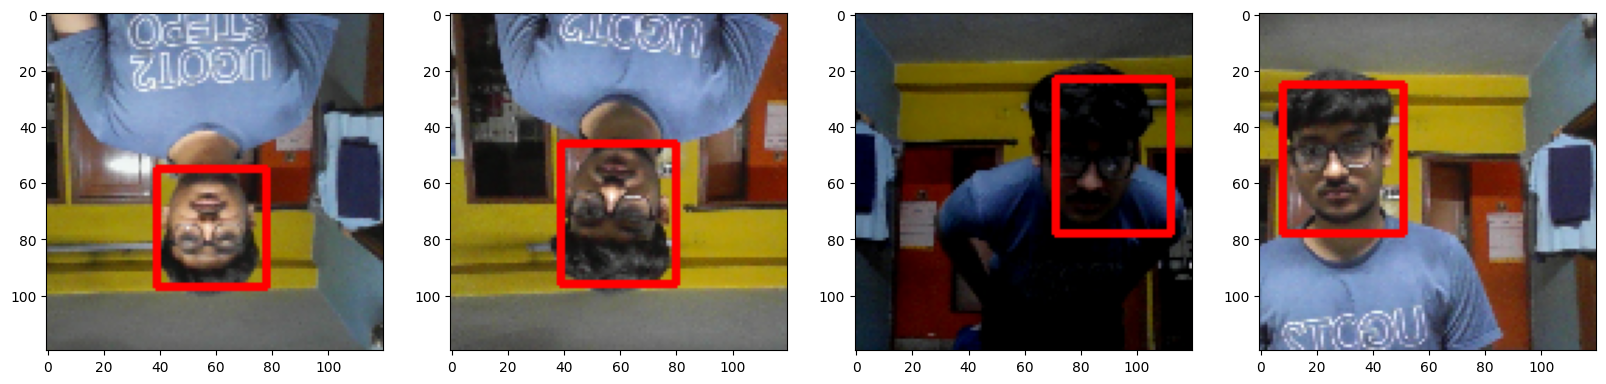

In [184]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (test_sample[0][idx]*255).astype(np.uint8)
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [172]:
from tensorflow.keras.models import load_model

In [173]:
facetracker.save('facetracker.h5')

In [174]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()